## Infer regression traits from input images

Source: https://walkwithfastai.com/Multi_Point_Regression

In [1]:
## !pip install mlxtend

In [2]:
################################################
##
## Infer regression traits from input images
##
################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import glob
import os
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap
from PIL import Image
from fastai.vision.all import *

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)




In [3]:
opt_img_size   = 256
opt_channels   = 3
opt_batch_size = 8

## original image shape = (2848, 4272, 3)


## Read in images

In [4]:

#######################################################

full_path = '/Users/user/Desktop/UGA_agi/code/data/'

#######################################################


In [5]:

images_path = full_path
## dir_list = os.listdir(images_path)
dir_list = [f for f in os.listdir(images_path) if f.endswith('.JPG')]
print(dir_list)



['IMG_7009.JPG', 'IMG_6868.JPG', 'IMG_7223.JPG', 'IMG_7237.JPG', 'IMG_6934.JPG', 'IMG_7394.JPG', 'IMG_7380.JPG', 'IMG_7419.JPG', 'IMG_7357.JPG', 'IMG_7343.JPG', 'IMG_7425.JPG', 'IMG_7169.JPG', 'IMG_7424.JPG', 'IMG_7430.JPG', 'IMG_7356.JPG', 'IMG_7418.JPG', 'IMG_7395.JPG', 'IMG_6909.JPG', 'IMG_6841.JPG', 'IMG_6869.JPG', 'IMG_6857.JPG', 'IMG_6894.JPG', 'IMG_7220.JPG', 'IMG_6880.JPG', 'IMG_7397.JPG', 'IMG_7354.JPG', 'IMG_7432.JPG', 'IMG_7157.JPG', 'IMG_7355.JPG', 'IMG_7369.JPG', 'IMG_6936.JPG', 'IMG_7221.JPG', 'IMG_6881.JPG', 'IMG_7741.JPG', 'IMG_6852.JPG', 'IMG_6846.JPG', 'IMG_6891.JPG', 'IMG_6885.JPG', 'IMG_7225.JPG', 'IMG_6926.JPG', 'IMG_7392.JPG', 'IMG_7345.JPG', 'IMG_7423.JPG', 'IMG_7437.JPG', 'IMG_7351.JPG', 'IMG_7184.JPG', 'IMG_7190.JPG', 'IMG_7191.JPG', 'IMG_7378.JPG', 'IMG_7436.JPG', 'IMG_7422.JPG', 'IMG_6933.JPG', 'IMG_7393.JPG', 'IMG_7387.JPG', 'IMG_6927.JPG', 'IMG_6884.JPG', 'IMG_6847.JPG', 'IMG_6853.JPG', 'IMG_6845.JPG', 'IMG_6851.JPG', 'IMG_6879.JPG', 'IMG_7232.JPG', 'IMG_69

In [6]:
print(len(dir_list))

295


In [7]:

    
paths = glob.glob(full_path + "/*.JPG") # Grabbing all the image file names
print(len(paths))


295


In [8]:

np.random.seed(123)
paths_subset = np.random.choice(paths, 295, replace=False) 
rand_idxs = np.random.permutation(295)

train_idxs = rand_idxs[:207] 
val_idxs   = rand_idxs[207:] 

train_paths = paths_subset[train_idxs]
val_paths   = paths_subset[val_idxs]

print(len(train_paths), len(val_paths))

207 88


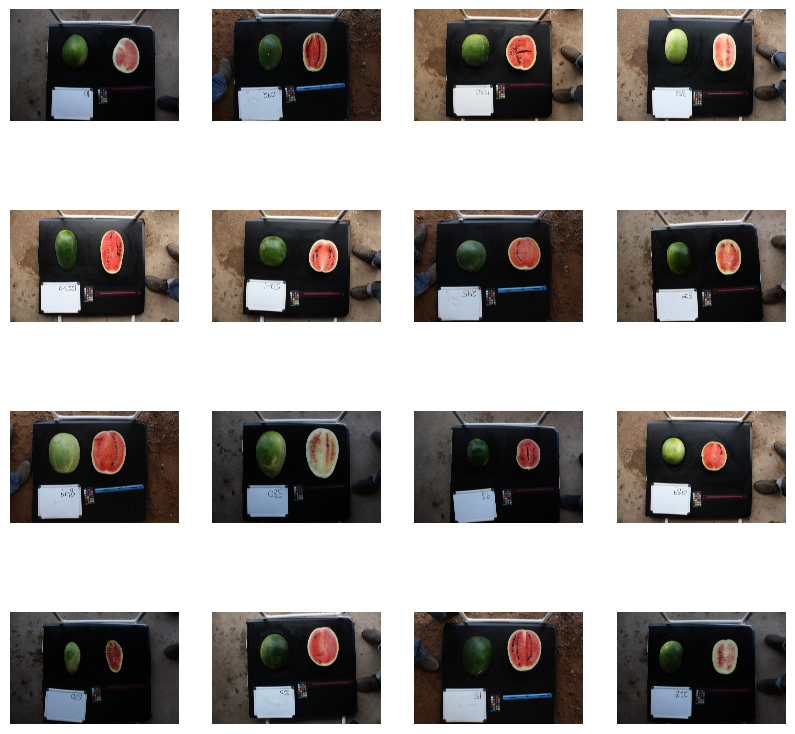

In [9]:

_, axes = plt.subplots(4, 4, figsize=(10, 10))

for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")


## Read data from CSV

In [10]:

traits_raw_data = pd.read_csv('traitsData/PhenotypeDataUGA.csv')


In [11]:

headers_list = traits_raw_data.columns.values.tolist()
print(headers_list)
print(len(headers_list))


for i, name in enumerate(headers_list):
    print((i, name))


['line', 'photo_id', 'perimeter1_cm', 'width1_cm', 'heigth1_cm', 'perimeter2_cm', 'width2_cm', 'heigth2_cm', 'prox_angl_macr', 'distal_angl_macr', 'tomat_pericap_area', 'tomat_pericap_area_ratio', 'tomat_pericap_thick', 'tomat_pericap_thick_ratio']
14
(0, 'line')
(1, 'photo_id')
(2, 'perimeter1_cm')
(3, 'width1_cm')
(4, 'heigth1_cm')
(5, 'perimeter2_cm')
(6, 'width2_cm')
(7, 'heigth2_cm')
(8, 'prox_angl_macr')
(9, 'distal_angl_macr')
(10, 'tomat_pericap_area')
(11, 'tomat_pericap_area_ratio')
(12, 'tomat_pericap_thick')
(13, 'tomat_pericap_thick_ratio')


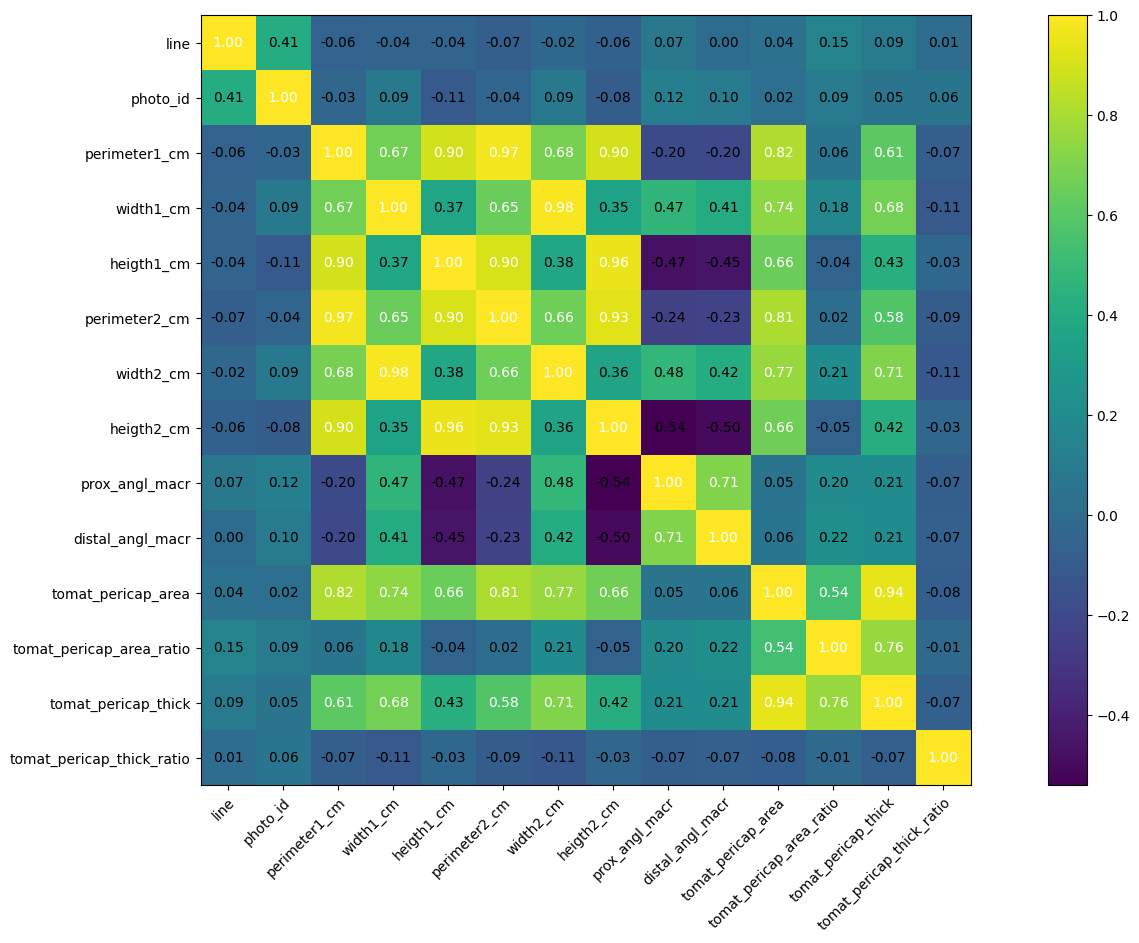

In [12]:

trait_names = ['line', 'photo_id', 'perimeter1_cm', 'width1_cm', 'heigth1_cm', 'perimeter2_cm', 
               'width2_cm', 'heigth2_cm', 'prox_angl_macr', 'distal_angl_macr', 'tomat_pericap_area', 
               'tomat_pericap_area_ratio', 'tomat_pericap_thick', 'tomat_pericap_thick_ratio']

rm_inf_traits_raw_data = traits_raw_data

# remove any (inf, -inf, nan) values
## rm_inf_traits_raw_data = rm_inf_traits_raw_data.replace([np.inf, -np.inf], np.nan).dropna()

rm_inf_traits_raw_data = traits_raw_data

cm = np.corrcoef(rm_inf_traits_raw_data[trait_names].values.T)

## cm = np.corrcoef(traits_raw_data[trait_names].values.T)
hm = heatmap(cm, row_names=trait_names, column_names=trait_names, figsize=(20, 10))
plt.show()



## Get traits (y) as tensor

In [13]:

def get_traits_as_tensor(fname):
    
    fname = fname.replace(  "/Users/user/Desktop/UGA_agi/code/data/"  ,  ""  )
    fname = fname.replace(  ".JPG"  ,  ""  )
    fname = fname.replace(  "IMG_"  ,  ""  )
        
    traits_row_for_img = traits_raw_data.loc[traits_raw_data['photo_id'] == int(fname) ]
    
    traits_row_for_img_np = traits_row_for_img.to_numpy()
    
    return traits_row_for_img_np




## Making X and y


In [14]:
img_shape = (opt_channels, opt_img_size, opt_img_size)

cuda = True if torch.cuda.is_available() else False

In [15]:
img_shape

(3, 256, 256)

In [16]:

fns = glob.glob(full_path + "/*.JPG") # Grabbing all the image file names


In [17]:

list_imgs = []
list_label_vectors = []

for img_name in fns:
    
    my_img = Image.open(img_name)
    
    my_img = my_img.resize((opt_img_size, opt_img_size))

    img_np = np.array(my_img)

    
    list_imgs.append(img_np)
    
    tensor_of_traits_per_img = get_traits_as_tensor(img_name)
    
    list_label_vectors.append(  tensor_of_traits_per_img[0]    )



## Imgs not resized

In [18]:
'''
for img_name in fns:
    
    my_img = Image.open(img_name)
    img_np = np.array(my_img)
    print(  img_np.shape   )
'''

'\nfor img_name in fns:\n    \n    my_img = Image.open(img_name)\n    img_np = np.array(my_img)\n    print(  img_np.shape   )\n'

## View Data resized

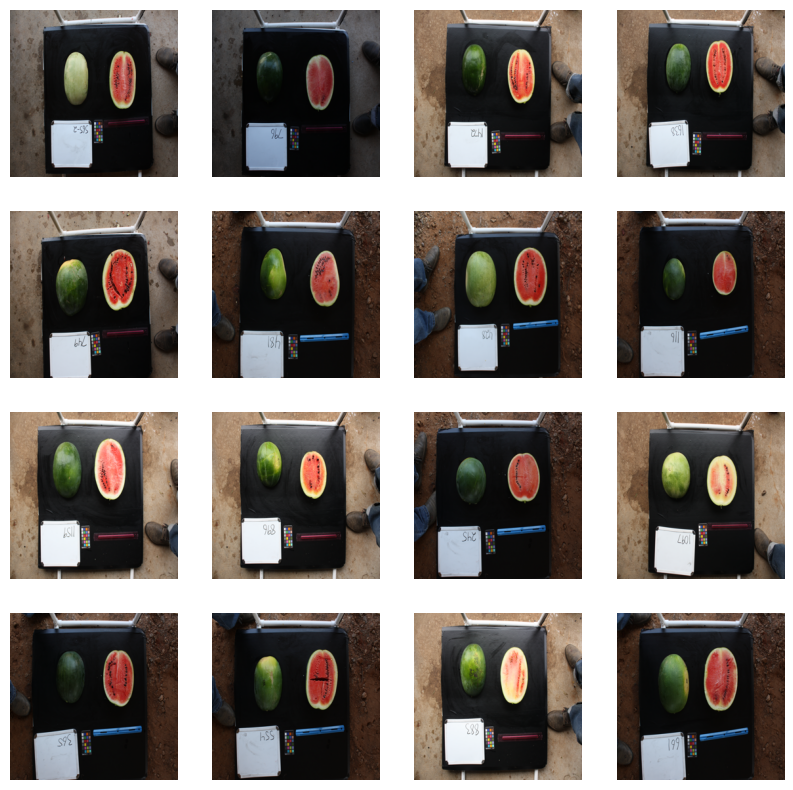

In [19]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))

for ax, img_path in zip(axes.flatten(), fns):
    a_img = Image.open(img_path)
    ax.imshow(a_img.resize((opt_img_size, opt_img_size)))
    ax.axis("off")

## Create X and y

In [20]:

X = np.array( list_imgs)

y = np.array( list_label_vectors )

print(X.shape)
print(y.shape)


(295, 256, 256, 3)
(295, 14)


In [21]:
#######################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#######################################################

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(206, 256, 256, 3)
(89, 256, 256, 3)
(206, 14)
(89, 14)


In [22]:
## fix data type
X_train  = X_train.astype(np.float32)
X_test   = X_test.astype(np.float32)
y_train  = y_train.astype(np.float32)
y_test   = y_test.astype(np.float32)

In [23]:
X_train_tr  = torch.from_numpy(X_train)
X_test_tr   = torch.from_numpy(X_test)
y_train_tr  = torch.from_numpy(y_train)
y_test_tr   = torch.from_numpy(y_test)

In [24]:
X_train_tr  = torch.permute(X_train_tr , (0, 3, 1, 2))
X_test_tr   = torch.permute(X_test_tr ,  (0, 3, 1, 2))

In [25]:
print(X_train_tr.shape)
print(X_test_tr.shape)
print(y_train_tr.shape)
print(y_test_tr.shape)

torch.Size([206, 3, 256, 256])
torch.Size([89, 3, 256, 256])
torch.Size([206, 14])
torch.Size([89, 14])


In [26]:

## train_ds = TensorDataset(   X_train_tr, y_train_tr)

train_ds = list(     zip(X_train_tr, y_train_tr)      )


In [27]:

## test_ds  = TensorDataset(X_test_tr , y_test_tr )

test_ds = list(zip(   X_test_tr, y_test_tr))


In [28]:



train_dl = DataLoader(train_ds, batch_size=8)


test_dl  = DataLoader(test_ds,  batch_size=8)




In [29]:

the_dls = DataLoaders(train_dl, test_dl)


In [30]:
'''

dls = DataLoader(
    train_ds, 
    batch_size=opt_batch_size, 
    shuffle=True
)

'''



'\n\ndls = DataLoader(\n    train_ds, \n    batch_size=opt_batch_size, \n    shuffle=True\n)\n\n'

In [31]:

xb,yb = the_dls.one_batch()
xb.shape, yb.shape
     


(torch.Size([8, 3, 256, 256]), torch.Size([8, 14]))

## Model

In [32]:

learn = cnn_learner( 
              the_dls, 
              resnet18, 
              metrics=[  MSELossFlat()   ], 
              loss_func=L1LossFlat(),
              normalize=False,
              n_out = 14,
              ## y_range=(0,1),           ## when data normalized
)


/Users/user/opt/anaconda3/envs/py37_GANs_Torch/lib/python3.7/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/Users/user/opt/anaconda3/envs/py37_GANs_Torch/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/Users/user/opt/anaconda3/envs/py37_GANs_Torch/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAUL

In [33]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,None,time
0,595.783447,598.748108,3684569.250000,01:02


epoch,train_loss,valid_loss,None,time
0,595.661316,598.630310,3684265.250000,01:33
1,595.575073,598.495361,3683993.250000,01:33
